---
title: 'Breaching 1.5°C: Give me the odds'
subtitle: 'Probability at the Paris Agreement notebook'
author:
  - name: J. Eduardo Vera-Valdés
    email: eduardo@math.aau.dk
    url: 'https://everval.github.io'
    affiliations:
      - name: Aalborg University
        department: Department of Mathematical Sciences
        country: Denmark
    orcid: 0000-0002-0337-8055
    corresponding: true
  - name: Olivia Kvist
    email: omtk@math.aau.dk
    affiliations:
      - name: Aalborg University
        department: Department of Mathematical Sciences
        country: Denmark
abstract: |
  This is the replication notebook to the article "Breaching 1.5°C: Give me the odds" by J. Eduardo Vera-Valdés and Olivia Kvist. It contains the code used to generate the figures and tables in the article. The code is written in `Julia` and it is organized into sections that correspond to the sections of the paper.
format:
  html:
    mainfont: Georgia, serif
    html-math-method: katex
    theme: litera
    code-fold: true
    title-block-banner: "#eef7ee"
#  typst:
#    mainfont: Computer Modern
#    fontsize: 12pt
#    papersize: a4
execute:
  enabled: true
  cache: true
  freeze: auto
engine: julia
#jupyter: julia-1.11
bibliography: library.bib
---

## 0. Load Packages

In [1]:
#| label: load-packages
#| echo: false
#| output: false
#| warning: false
#| include: false

using Pkg
Pkg.activate(pwd())
using Plots, Dates, CSV, DataFrames, LongMemory, Statistics, MarSwitching, Random
include("TrendEstimators.jl")
using .TrendEstimators

Random.seed!(123456)
theme(:ggplot2)

  Activating 

project at `~/Library/CloudStorage/OneDrive-AalborgUniversitet/Research/CLIMATE/Paris Goal/Odds-of-breaching-1.5C`


## 1. Load Data

### 1.1 Temperature

In [2]:
rawtemp = CSV.read("data/HadCRUT.5.0.2.0.analysis.ensemble_series.global.monthly.csv", DataFrame)
first(rawtemp, 5)

5×203 DataFrame
 Row │ Time        Fraction of area represented  Coverage uncertainty (1 sigma ⋯
     │ Date        Float64                       Float64                       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 1850-01-01                      0.53036                        0.12529  ⋯
   2 │ 1850-02-01                      0.471513                       0.15873
   3 │ 1850-03-01                      0.443069                       0.146062
   4 │ 1850-04-01                      0.477059                       0.116737
   5 │ 1850-05-01                      0.487233                       0.095900 ⋯
                                                             201 columns omitted

Saving the mean of the ensemble to be used later.

In [3]:
menstemp = reduce(+, eachcol(rawtemp[:, 4:203])) ./ ncol(rawtemp[:, 4:203]);
oldbase = mean(menstemp[(rawtemp.Time.>Date(1850, 1, 1)).&(rawtemp.Time.<Date(1900, 1, 1))]);
menstempind = menstemp .- oldbase;

### 1.2 El Niño

Loading the data and removing the missing values. They appear only at the beginning of the time series.

The data has been neatly collected by https://bmcnoldy.earth.miami.edu/tropics/oni/

In [4]:
rawnino = CSV.read("data/Nino_1854_2024.csv", DataFrame)
delete!(rawnino, rawnino.ONI .== -99.99)
first(rawnino, 5)

5×7 DataFrame
 Row │ YEAR   MON/MMM  NINO34_MEAN  NINO34_CLIM  NINO34_ANOM  ONI      PHASE   ⋯
     │ Int64  Int64    Float64      Float64      Float64      Float64  String1 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  1871        2        25.59        26.03        -0.45    -0.26  N       ⋯
   2 │  1871        3        26.66        26.55         0.11     0.08  N
   3 │  1871        4        27.57        26.99         0.58     0.31  N
   4 │  1871        5        27.4         27.16         0.24     0.36  N
   5 │  1871        6        27.17        26.93         0.24     0.26  N       ⋯

### 1.3 Merging Data

Matching to first non-missing value of El Niño

In [5]:
date_nino = Date.(rawnino[!, 1], rawnino[!, 2])
tempnino = rawtemp[rawtemp.Time.>=date_nino[1], :]
tempnino[!, :ONI] = rawnino.ONI
rename!(tempnino, :Time => :Date)
first(tempnino, 5)

5×204 DataFrame
 Row │ Date        Fraction of area represented  Coverage uncertainty (1 sigma ⋯
     │ Date        Float64                       Float64                       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 1871-02-01                      0.515577                       0.123416 ⋯
   2 │ 1871-03-01                      0.561066                       0.134799
   3 │ 1871-04-01                      0.649393                       0.091451
   4 │ 1871-05-01                      0.569534                       0.100992
   5 │ 1871-06-01                      0.581247                       0.094669 ⋯
                                                             202 columns omitted

### 1.4 Rebaseline to pre-industrial levels (1850-1900)

In [6]:
for ii = 1:200
    newbaseline = mean(tempnino[(tempnino.Date.>Date(1850, 1, 1)).&(tempnino.Date.<Date(1900, 1, 1)), 3+ii])
    tempnino[!, 3+ii] = tempnino[!, 3+ii] .- newbaseline
end

### 1.5 Data at the Paris Agreement

In [7]:
delete!(tempnino, tempnino.Date .> Date(2016, 12, 1));
T = length(tempnino.Date)
last(tempnino, 5)

5×204 DataFrame
 Row │ Date        Fraction of area represented  Coverage uncertainty (1 sigma ⋯
     │ Date        Float64                       Float64                       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2016-08-01                      0.991773                      0.0172583 ⋯
   2 │ 2016-09-01                      0.992085                      0.0125059
   3 │ 2016-10-01                      0.99364                       0.0107343
   4 │ 2016-11-01                      0.995774                      0.0049154
   5 │ 2016-12-01                      0.998609                      0.0017856 ⋯
                                                             202 columns omitted

## 2. Markov Switching Model

Two specifications are considered: one with 3 regimes (El Niño, La Niña, and Neutral) and one with 7 regimes (Very Strong El Niño, Strong El Niño, Moderate El Niño, Neutral, Moderate La Niña, Strong La Niña, and Very Strong La Niña).

In [8]:
nino_model3 = MSModel(tempnino[!, :ONI], 3);
summary_msm(nino_model3);

Markov Switching Model with 3 regimes


# of observations:         1751 AIC:                      2342.501


# of estimated parameters:   12 BIC:                      2408.116
Error distribution:    Gaussian Instant. adj. R^2:           0.709
Loglikelihood:          -1159.3 Step-ahead adj. R^2:        0.5987
-----------------------------------------------------------------
------------------------------
Summary of regime 1: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |      1.21  |       0.043  |   28.003  |    < 1e-3  
σ            |     0.525  |       0.014  |   37.692  |    < 1e-3  


-------------------------------------------------------------------
Expected regime duration: 9.98 periods
-------------------------------------------------------------------
------------------------------
Summary of regime 2: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |    -0.745  |       0.033  |  -22.697  |    < 1e-3  


σ            |     0.417  |        0.01  |   41.138  |    < 1e-3  
-------------------------------------------------------------------
Expected regime duration: 15.94 periods
-------------------------------------------------------------------
------------------------------
Summary of regime 3: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |     0.181  |       0.039  |    4.696  |    < 1e-3  
σ            |     0.271  |       0.014  |   19.665  |    < 1e-3  
-------------------------------------------------------------------
Expected regime duration: 7.68 periods
-------------------------------------------------------------------
left-stochastic transition matrix: 
          | regime 1   | regime 2   | regime 3
----------------------------------------------------
 regime 1 |   89.985%  |      0.0%  |     5.87%  |
 regime 2 |      0.0%  |   93.726%  |    7.

In [9]:
nino_model5 = MSModel(tempnino[!, :ONI], 5);
summary_msm(nino_model5);

Markov Switching Model with 5 regimes


# of observations:         1751 AIC:                      2232.031
# of estimated parameters:   30 BIC:                       2396.07
Error distribution:    Gaussian Instant. adj. R^2:           0.627
Loglikelihood:          -1086.0 Step-ahead adj. R^2:        0.5488
-----------------------------------------------------------------
------------------------------
Summary of regime 1: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |    -0.092  |       0.019  |   -4.982  |    < 1e-3  
σ            |     0.117  |       0.017  |    6.668  |    < 1e-3  


-------------------------------------------------------------------
Expected regime duration: 1.50 periods
-------------------------------------------------------------------
------------------------------
Summary of regime 2: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |     0.317  |       0.012  |   25.609  |    < 1e-3  


σ            |     0.191  |       0.012  |   15.939  |    < 1e-3  
-------------------------------------------------------------------
Expected regime duration: 4.87 periods
-------------------------------------------------------------------
------------------------------
Summary of regime 3: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |    -0.616  |        0.04  |  -15.395  |    < 1e-3  
σ            |     0.319  |       0.007  |   47.125  |    < 1e-3  


-------------------------------------------------------------------
Expected regime duration: 11.30 periods
-------------------------------------------------------------------
------------------------------
Summary of regime 4: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |    -0.478  |       0.064  |   -7.466  |    < 1e-3  


σ            |     1.547  |       0.021  |   73.803  |    < 1e-3  
-------------------------------------------------------------------
Expected regime duration: 5.35 periods
-------------------------------------------------------------------
------------------------------
Summary of regime 5: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |     1.139  |        0.03  |   37.999  |    < 1e-3  
σ            |     0.598  |       0.012  |   47.915  |    < 1e-3  


-------------------------------------------------------------------
Expected regime duration: 12.24 periods
-------------------------------------------------------------------
left-stochastic transition matrix: 
          | regime 1   | regime 2   | regime 3   | regime 4   | regime 5
------------------------------------------------------------------------------
 regime 1 |    33.49%  |    5.387%  |    1.046%  |      0.0%  |      0.0%  |
 regime 2 |   25.878%  |   79.466%  |    0.446%  |      0.0%  |    8.171%  |
 regime 3 |   33.518%  |    1.536%  |   91.149%  |   18.706%  |      0.0%  |
 regime 4 |      0.0%  |      0.0%  |    2.966%  |   81.294%  |      0.0%  |
 regime 5 |    7.114%  |   13.611%  |    4.393%  |      0.0%  |   91.829%  |


In [10]:
nino_model7 = MSModel(tempnino[!, :ONI], 7);
summary_msm(nino_model7);

Markov Switching Model with 7 regimes


# of observations:         1751 AIC:                      1119.398
# of estimated parameters:   56 BIC:                      1425.603
Error distribution:    Gaussian Instant. adj. R^2:          0.9053
Loglikelihood:           -503.7 Step-ahead adj. R^2:        0.7855
-----------------------------------------------------------------
------------------------------
Summary of regime 1: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |     0.543  |       0.011  |   48.849  |    < 1e-3  
σ            |     0.132  |       0.006  |   22.206  |    < 1e-3  


-------------------------------------------------------------------
Expected regime duration: 3.51 periods
-------------------------------------------------------------------
------------------------------
Summary of regime 2: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |    -1.183  |       0.028  |  -42.172  |    < 1e-3  


σ            |     0.323  |       0.011  |    29.35  |    < 1e-3  
-------------------------------------------------------------------
Expected regime duration: 8.91 periods
-------------------------------------------------------------------
------------------------------
Summary of regime 3: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |    -0.466  |       0.015  |  -30.539  |    < 1e-3  
σ            |      0.22  |       0.005  |   46.246  |    < 1e-3  


-------------------------------------------------------------------
Expected regime duration: 5.93 periods
-------------------------------------------------------------------
------------------------------
Summary of regime 4: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |     0.185  |       0.017  |   11.225  |    < 1e-3  


σ            |     0.129  |       0.017  |    7.379  |    < 1e-3  
-------------------------------------------------------------------
Expected regime duration: 5.74 periods
-------------------------------------------------------------------
------------------------------
Summary of regime 5: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |     1.875  |       0.045  |   41.325  |    < 1e-3  
σ            |     0.448  |       0.019  |   23.053  |    < 1e-3  


-------------------------------------------------------------------
Expected regime duration: 5.63 periods
-------------------------------------------------------------------
------------------------------
Summary of regime 6: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |     1.057  |       0.024  |    44.26  |    < 1e-3  


σ            |     0.226  |       0.009  |   24.771  |    < 1e-3  
-------------------------------------------------------------------
Expected regime duration: 4.11 periods
-------------------------------------------------------------------
------------------------------
Summary of regime 7: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |    -0.012  |        0.04  |   -0.298  |     0.765  
σ            |       0.1  |       0.021  |    4.874  |    < 1e-3  


-------------------------------------------------------------------
Expected regime duration: 2.07 periods
-------------------------------------------------------------------
left-stochastic transition matrix: 
          | regime 1   | regime 2   | regime 3   | regime 4   | regime 5   | regime 6   | regime 7
--------------------------------------------------------------------------------------------------------
 regime 1 |   71.534%  |      0.0%  |      0.0%  |    6.923%  |      0.0%  |   10.078%  |      0.0%  |
 regime 2 |      0.0%  |   88.772%  |    5.664%  |      0.0%  |      0.0%  |      0.0%  |      0.0%  |
 regime 3 |      0.0%  |   11.228%  |   83.131%  |      0.0%  |      0.0%  |      0.0%  |   44.851%  |
 regime 4 |   11.859%  |      0.0%  |    9.635%  |   82.574%  |      0.0%  |    0.432%  |    3.519%  |
 regime 5 |      0.0%  |      0.0%  |      0.0%  |      0.0%  |   82.245%  |    7.776%  |      0.0%  |
 regime 6 |   13.577%  |      0.0%  |      0.0%  |      0.0%  |   12.0

Looking at the BIC, the 7-regime model is preferred.
Hence, we continue with the 7-regime model.

## 3. Trend Model

### Fitting the trend model

#### One example, quadratic trend

Fitting the quadratic trend model to the temperature anomalies and to the temperature anomalies with the El Niño index as an exogenous variable.

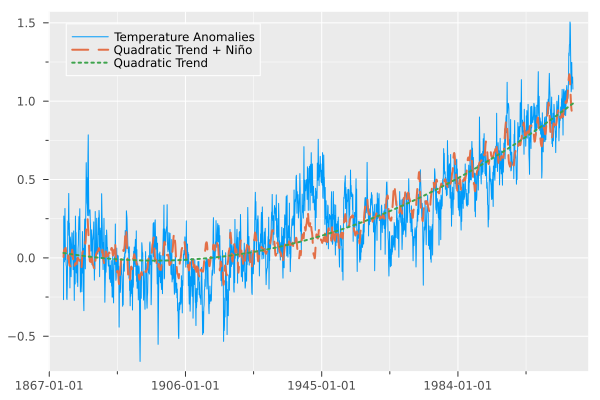

In [11]:
qmodel_exo = TrendEstimators.quad_trend_est(tempnino[:, 10], tempnino.ONI)
qmodel = TrendEstimators.quad_trend_est(tempnino[:, 10])
plot(tempnino.Date, tempnino[:, 10], linewidth=1, label="Temperature Anomalies", xlabel="", ylabel="", legend=:topleft)
plot!(tempnino.Date, qmodel_exo.Yfit, linestyle=:dash, linewidth=2, label="Quadratic Trend + Niño", color=2)
plot!(tempnino.Date, qmodel.Yfit, linestyle=:dot, linewidth=2, label="Quadratic Trend", color=3)

Forecasting the quadratic trend model in two ways: only the quadratic trend and the quadratic trend with the long memory component.

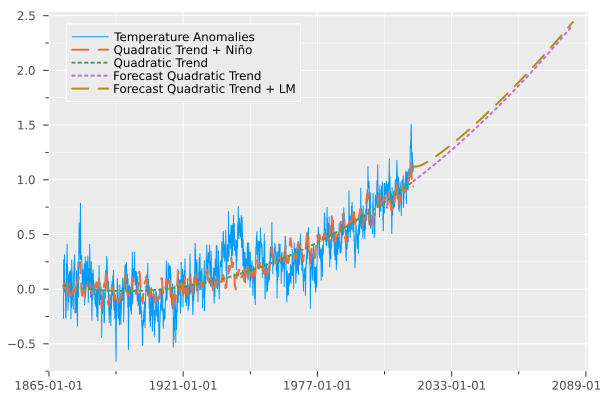

In [12]:
h = 800
date_for = collect((tempnino.Date[1]+Dates.Month(T)):Month(1):(tempnino.Date[1]+Dates.Month(T - 1)+Dates.Month(h)));
qmodel_forecast = TrendEstimators.quad_trend_forecast(qmodel, h);
plot!(date_for, qmodel_forecast.Yforecastmean, linestyle=:dot, linewidth=2, label="Forecast Quadratic Trend", color=4)
plot!(date_for, qmodel_forecast.Yforecasterr, linestyle=:dash, linewidth=2, label="Forecast Quadratic Trend + LM", color=5)
#plot!(xlims=(Date(2016,1,1),Date(2050,1,1)))

Final forecasting adding the exogenous variable El Niño.

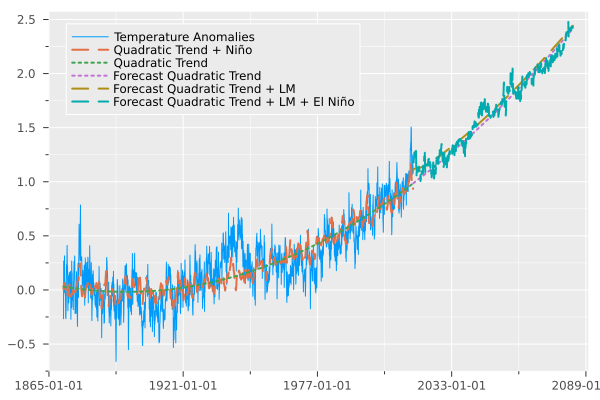

In [13]:
simul_nino = generate_msm(nino_model7, h)[1]
qmodel_exo_forecast = TrendEstimators.quad_trend_forecast(qmodel_exo, h, simul_nino)
plot!(date_for, qmodel_exo_forecast.Yforecasterr, linestyle=:dash, linewidth=2, label="Forecast Quadratic Trend + LM + El Niño", color=6)

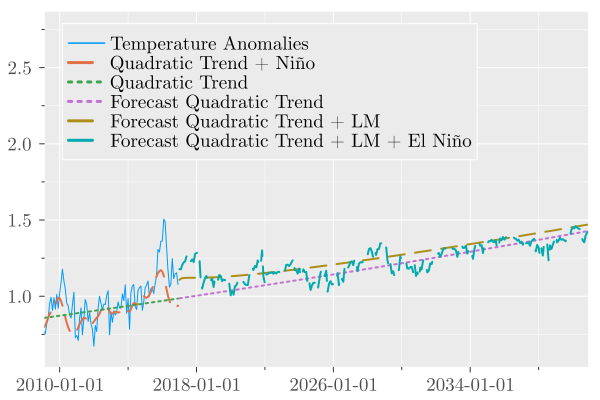

In [14]:
plot!(fontfamily="Computer Modern", legendfontsize=12, tickfontsize=12, titlefontfamily="Computer Modern", legendfontfamily="Computer Modern", tickfontfamily="Computer Modern", ylabelfontsize=12, xlabelfontsize=12, titlefontsize=16, xlabel="", ylabel="", ylims=(0.6, 2.8), xlims=(Date(2010, 1, 1), Date(2040, 1, 1)), legend=:topleft)

### A second example, broken linear trend

Fitting the broken linear trend model to the temperature anomalies and to the temperature anomalies with the El Niño index as an exogenous variable.

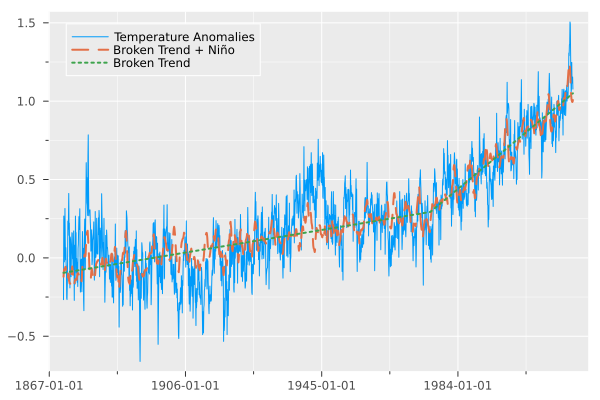

In [15]:
bmodel = TrendEstimators.broken_trend_est(tempnino[:, 10])
bmodel_exo = TrendEstimators.broken_trend_est(tempnino[:, 10], tempnino.ONI)
plot(tempnino.Date, tempnino[:, 10], linewidth=1, label="Temperature Anomalies", xlabel="", ylabel="", legend=:topleft)
plot!(tempnino.Date, bmodel_exo.Yfit, linestyle=:dash, linewidth=2, label="Broken Trend + Niño", color=2)
plot!(tempnino.Date, bmodel.Yfit, linestyle=:dot, linewidth=2, label="Broken Trend", color=3)

Forecasting the broken linear trend model in two ways: only the broken linear trend and the broken linear trend with the long memory component.

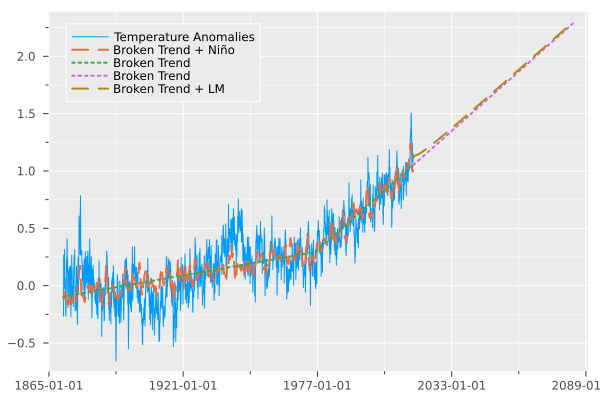

In [16]:
date_for = collect((tempnino.Date[1]+Dates.Month(T)):Month(1):(tempnino.Date[1]+Dates.Month(T - 1)+Dates.Month(h)));
bmodel_forecast = TrendEstimators.broken_trend_forecast(bmodel, h);
plot!(date_for, bmodel_forecast.Yforecastmean, linestyle=:dot, linewidth=2, label="Broken Trend", color=4)
plot!(date_for, bmodel_forecast.Yforecasterr, linestyle=:dash, linewidth=2, label="Broken Trend + LM", color=5)

Final forecasting adding the exogenous variable El Niño.

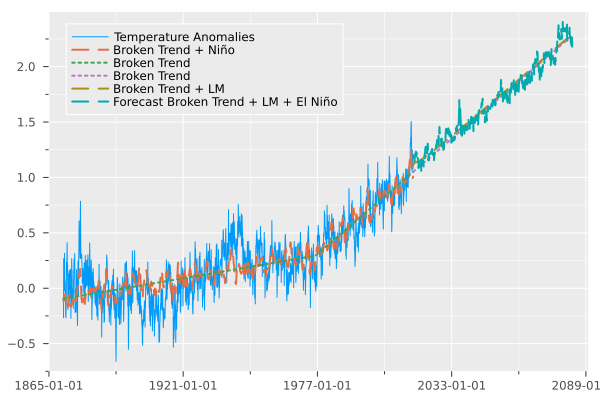

In [17]:
simul_nino = generate_msm(nino_model7, h)[1]
bmodel_exo_forecast = TrendEstimators.broken_trend_forecast(bmodel_exo, h, simul_nino)
plot!(date_for, bmodel_exo_forecast.Yforecasterr, linestyle=:dash, linewidth=2, label="Forecast Broken Trend + LM + El Niño", color=6)

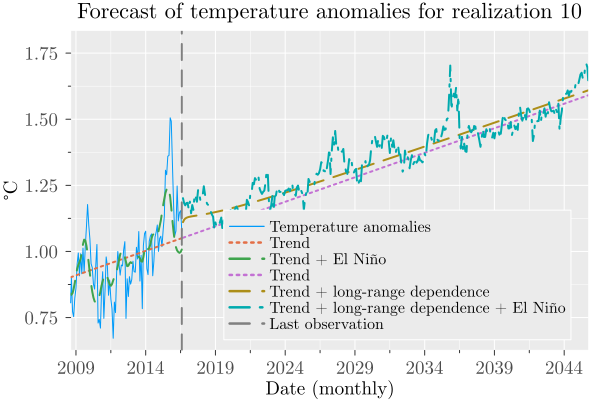

In [18]:
#| label: fig-models-forecasts-prepa
#| fig-cap: Forecast of temperature anomalies for realization 10 of the HadCRUT5 dataset. The forecast is based on the broken trend model with long-range dependence and El Niño as an exogenous variable. A simulated El Niño series using a Markov-switching model with 7 states was used to generate the forecast.

fulldate = collect((tempnino.Date[1]):Month(1):date_for[end])

plot(tempnino.Date, tempnino[:, 10], linewidth=1, label="Temperature anomalies", xlabel="Date (monthly)", ylabel="°C", legend=:bottomright, title="Forecast of temperature anomalies for realization 10")
plot!(tempnino.Date, bmodel.Yfit, linestyle=:dot, linewidth=2, label="Trend", color=2)
plot!(tempnino.Date, bmodel_exo.Yfit, linestyle=:dash, linewidth=2, label="Trend + El Niño", color=3)
plot!(date_for, bmodel_forecast.Yforecastmean, linestyle=:dot, linewidth=2, label="Trend", color=4)
plot!(date_for, bmodel_forecast.Yforecasterr, linestyle=:dash, linewidth=2, label="Trend + long-range dependence", color=5)
plot!(date_for, bmodel_exo_forecast.Yforecasterr, linestyle=:dashdot, linewidth=2, label="Trend + long-range dependence + El Niño", color=6)
vline!([tempnino.Date[end]], label="Last observation", color=:gray, linewidth=2, linestyle=:dash)
plot!(fontfamily="Computer Modern", legendfontsize=10, tickfontsize=12, titlefontfamily="Computer Modern", legendfontfamily="Computer Modern", tickfontfamily="Computer Modern", ylabelfontsize=12, xlabelfontsize=12, titlefontsize=14, ylims=(0.66, 1.8), xlims=(Date(2010, 1, 1), Date(2045, 1, 1)), yticks=0.75:0.25:1.75,  xticks=(fulldate[1660:60:end], Dates.format.(fulldate[1660:60:end], "Y")) )

### Selecting the best trend model

AIC

In [19]:
thisseries = tempnino[:, 10];
TrendEstimators.select_trend_model(TrendEstimators.trend_est(thisseries, tempnino.ONI), TrendEstimators.quad_trend_est(thisseries, tempnino.ONI), TrendEstimators.broken_trend_est(thisseries, tempnino.ONI))

("break", (β = [-0.10016852003856833, 0.00031332907360425246, 0.0012464691349785165, 0.07936505677116559], σ² = 0.027850629049125584, break_point = 1267, rss = 48.6550489488224, aic = -6266.159995701619, bic = -6244.288226372475, betavar = [8.201209142226718e-5 -8.986437084944063e-8 1.884892591682906e-7 -1.0085878242786883e-6; -8.986437084944061e-8 1.3039803301218045e-10 -3.637020597852166e-10 7.49661044729996e-10; 1.884892591682905e-7 -3.637020597852166e-10 1.9414801862852096e-9 -1.2303692379564436e-9; -1.008587824278688e-6 7.496610447299961e-10 -1.2303692379564436e-9 2.2089998057643436e-5], res = [-0.14604616423706884, 0.3600929573871306, 0.26516412525615823, 0.0449171133439957, 0.15637112994750801, 0.3849515761967872, 0.1728424687429314, 0.0435968079661922, 0.13065666570512785, 0.03478152628262174  …  0.32824372447647576, 0.21050956260143905, 0.10083484561699718, 0.022383273523150837, 0.061242481778206015, 0.24412672378843325, 0.11748075068925523, 0.15225477588694247, 0.156363216542

BIC

In [20]:
TrendEstimators.select_trend_model_bic(TrendEstimators.trend_est(thisseries, tempnino.ONI), TrendEstimators.quad_trend_est(thisseries, tempnino.ONI), TrendEstimators.broken_trend_est(thisseries, tempnino.ONI))

("break", (β = [-0.10016852003856833, 0.00031332907360425246, 0.0012464691349785165, 0.07936505677116559], σ² = 0.027850629049125584, break_point = 1267, rss = 48.6550489488224, aic = -6266.159995701619, bic = -6244.288226372475, betavar = [8.201209142226718e-5 -8.986437084944063e-8 1.884892591682906e-7 -1.0085878242786883e-6; -8.986437084944061e-8 1.3039803301218045e-10 -3.637020597852166e-10 7.49661044729996e-10; 1.884892591682905e-7 -3.637020597852166e-10 1.9414801862852096e-9 -1.2303692379564436e-9; -1.008587824278688e-6 7.496610447299961e-10 -1.2303692379564436e-9 2.2089998057643436e-5], res = [-0.14604616423706884, 0.3600929573871306, 0.26516412525615823, 0.0449171133439957, 0.15637112994750801, 0.3849515761967872, 0.1728424687429314, 0.0435968079661922, 0.13065666570512785, 0.03478152628262174  …  0.32824372447647576, 0.21050956260143905, 0.10083484561699718, 0.022383273523150837, 0.061242481778206015, 0.24412672378843325, 0.11748075068925523, 0.15225477588694247, 0.156363216542

Table with the AIC and BIC values for the different trend models.

In [21]:
[TrendEstimators.trend_est(thisseries, tempnino.ONI).aic TrendEstimators.quad_trend_est(thisseries, tempnino.ONI).aic TrendEstimators.broken_trend_est(thisseries, tempnino.ONI).aic;
TrendEstimators.trend_est(thisseries, tempnino.ONI).bic TrendEstimators.quad_trend_est(thisseries, tempnino.ONI).bic TrendEstimators.broken_trend_est(thisseries, tempnino.ONI).bic]

2×3 Matrix{Float64}:
 -5607.83  -6231.08  -6266.16
 -5591.42  -6209.21  -6244.29

## Computing the breach point

[ Info: Saved animation to /Users/jeddy/Library/CloudStorage/OneDrive-AalborgUniversitet/Research/CLIMATE/Paris Goal/Odds-of-breaching-1.5C/figures/breach_realization10_prePA.gif


Plots.AnimatedGif("/Users/jeddy/Library/CloudStorage/OneDrive-AalborgUniversitet/Research/CLIMATE/Paris Goal/Odds-of-breaching-1.5C/figures/breach_realization10_prePA.gif")
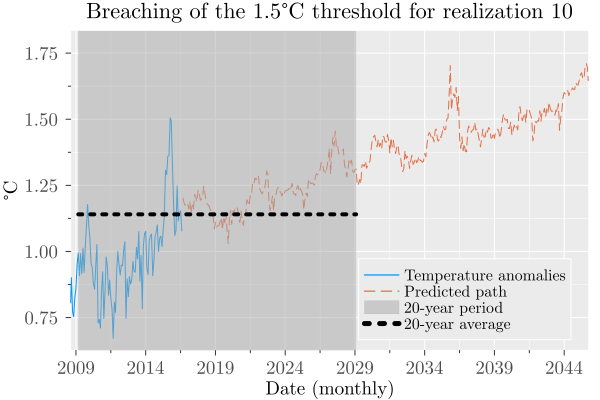

In [22]:
#| label: fig-breaching-gif-prepa
#| fig-cap: Breaching of the 1.5°C threshold for realization 10 of the HadCRUT5 dataset. The figure shows the temperature anomalies and the forecasted path for the next several months. The forecasted path is the same as in the previous figure. The 20-year period is highlighted in gray, and the 20-year average is shown as a black dashed line.

thisreal = [tempnino[:, 10]; bmodel_exo_forecast.Yforecasterr]

anim = @animate for ii = 30:24:360
    plot(fulldate[1:T], thisreal[1:T], linewidth=1, label="Temperature anomalies", xlabel="Date (monthly)", ylabel="°C", legend=:bottomright, title="Breaching of the 1.5°C threshold for realization 10")
    plot!(fulldate[T+1:end], thisreal[T+1:end], linewidth=1, label="Predicted path", color=2, linestyle=:dash)
    vspan!(fulldate[[T-119+ii,T+120+ii]], linecolor = :darkgray, fillcolor = :darkgray, label = "20-year period", alpha = 0.5)
    plot!(fulldate[[T-119+ii,T+120+ii]], [ mean(thisreal[T-119+ii:T+120+ii]), mean(thisreal[T-119+ii:T+120+ii])], label="20-year average", linewidth=4, linestyle=:dot, color = :black)
    plot!(fontfamily="Computer Modern", legendfontsize=10, tickfontsize=12, titlefontfamily="Computer Modern", legendfontfamily="Computer Modern", tickfontfamily="Computer Modern", ylabelfontsize=12, xlabelfontsize=12, titlefontsize=14, ylims=(0.66, 1.8), xlims=(Date(2010, 1, 1), Date(2045, 1, 1),), yticks=0.75:0.25:1.75,  xticks=(fulldate[1660:60:end], Dates.format.(fulldate[1660:60:end], "Y")) )
end

gif(anim, "figures/breach_realization10_prePA.gif", fps = 5)

Finding the breach point of the broken linear trend model.

In [23]:
breachreal10 = rolling_sample_mean(thisreal)
fulldate[breachreal10]

2040-05-01

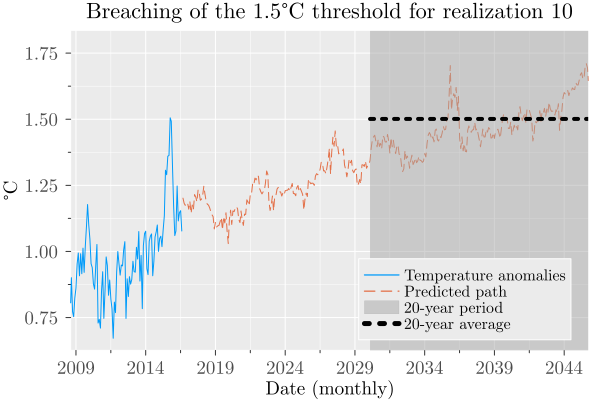

In [24]:
#| label: fig-breaching-static-prepa
#| fig-cap: Breaching of the 1.5°C threshold for realization 10 of the HadCRUT5 dataset. The figure shows the temperature anomalies and the forecasted path for the next several months. The 20-year period is highlighted in gray, and the 20-year average is shown as a black dashed line.

ps = plot(fulldate[1:T], thisreal[1:T], linewidth=1, label="Temperature anomalies", xlabel="Date (monthly)", ylabel="°C", legend=:bottomright, title="Breaching of the 1.5°C threshold for realization 10")
plot!(fulldate[T+1:end], thisreal[T+1:end], linewidth=1, label="Predicted path", color=2, linestyle=:dash)
vspan!(fulldate[[breachreal10-119,breachreal10+120]], linecolor = :darkgray, fillcolor = :darkgray, label = "20-year period", alpha = 0.5)
plot!(fulldate[[breachreal10-119,breachreal10+120]], [ mean(thisreal[breachreal10-119:breachreal10+120]), mean(thisreal[breachreal10-119:breachreal10+120])], label="20-year average", linewidth=4, linestyle=:dot, color = :black)
plot!(fontfamily="Computer Modern", legendfontsize=10, tickfontsize=12, titlefontfamily="Computer Modern", legendfontfamily="Computer Modern", tickfontfamily="Computer Modern", ylabelfontsize=12, xlabelfontsize=12, titlefontsize=14, ylims=(0.66, 1.8), xlims=(Date(2010, 1, 1), Date(2045, 1, 1),), yticks=0.75:0.25:1.75,  xticks=(fulldate[1660:60:end], Dates.format.(fulldate[1660:60:end], "Y")) )


## 4. Forecasting paths

Columns 4 to 203 are time series of the temperature anomalies for each realization. We fit the trend model to each realization. Column 204 is the El Niño index.

In [25]:
nsim = 5
matforecasts = zeros(h, 200 * nsim)
uncertainty = 1.96

for ii = 1:200

    thisseries = tempnino[!, 3+ii]

    test = TrendEstimators.trend_est(thisseries, tempnino.ONI)
    qtest = TrendEstimators.quad_trend_est(thisseries, tempnino.ONI)
    btest = TrendEstimators.broken_trend_est(thisseries, tempnino.ONI)

    model_selection = TrendEstimators.select_trend_model(test, qtest, btest)

    for jj = 1:nsim

        simul_nino = generate_msm(nino_model7, h)[1]

        if model_selection[1] == "trend"
            matforecasts[:, (ii-1)*nsim+jj] = TrendEstimators.trend_forecast(test, h, simul_nino, uncertainty).Yforecasterr
        elseif model_selection[1] == "quad"
            matforecasts[:, (ii-1)*nsim+jj] = TrendEstimators.quad_trend_forecast(qtest, h, simul_nino, uncertainty).Yforecasterr
        elseif model_selection[1] == "break"
            matforecasts[:, (ii-1)*nsim+jj] = TrendEstimators.broken_trend_forecast(btest, h, simul_nino, uncertainty).Yforecasterr
        else
            @warn "No model selected"
        end

    end
end

### Plotting the forecasts

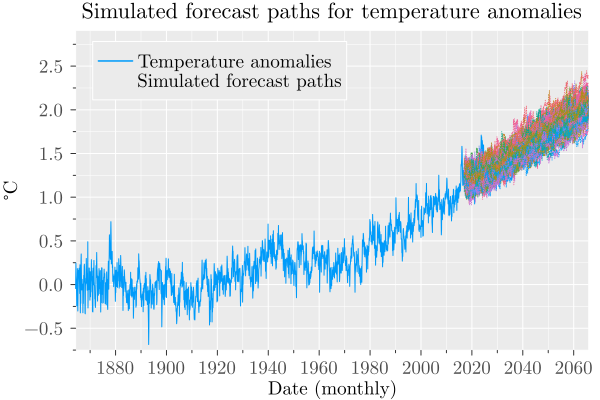

In [26]:
#| label: fig-paths-prePA
#| fig-cap: Simulated forecast paths for HadCRUT5 temperature anomalies. One hundred paths of a total of 1000 paths are shown to ease visualization. The forecasts are based on the best-fitting model for each realization, with El Niño as an exogenous variable. For ease of visualization, the mean of all temperature anomaly realizations is shown as a solid line.

plot(rawtemp.Time, menstempind, linewidth=1, label="Temperature anomalies", legend=:topleft, title="Simulated forecast paths for temperature anomalies", xlabel="Date (monthly)", ylabel="°C")
plot!(date_for, matforecasts[:,rand(1:200*nsim,100)], linestyle=:dot, linewidth=0.8, label="", xticks=(fulldate[108:240:end], Dates.format.(fulldate[108:240:end], "Y")) )
plot!(date_for, zeros(size(date_for,1)), color=nothing, label="Simulated forecast paths")
plot!(fontfamily="Computer Modern", legendfontsize=12, tickfontsize=12, titlefontfamily="Computer Modern", legendfontfamily="Computer Modern", tickfontfamily="Computer Modern", ylabelfontsize=12, xlabelfontsize=12, titlefontsize=14, ylims=(-0.65, 2.8), xlims=(Date(1870, 1, 1), Date(2060, 1, 1)))

## 5. Coverage of the prediction intervals

We compute the coverage of the prediction intervals for the predictions of the temperature anomalies at the Paris Agreement.

In [27]:
quantilesforecasts = zeros(h, 7)

for ii = 1:h
    quantilesforecasts[ii, :] = quantile(matforecasts[ii, :], [0.005, 0.025, 0.05, 0.5, 0.95, 0.975, 0.995 ])
end

### IPCC estimates

In [28]:
ipcc = CSV.read("data/ipcc-projections-sr15.csv", DataFrame)
first(ipcc, 5)

5×3 DataFrame
 Row │ year   min_t    max_t   
     │ Int64  Float64  Float64 
─────┼─────────────────────────
   1 │  1850   -0.023   -0.035
   2 │  1851   -0.022   -0.033
   3 │  1852   -0.021   -0.032
   4 │  1853   -0.02    -0.03
   5 │  1854   -0.019   -0.029

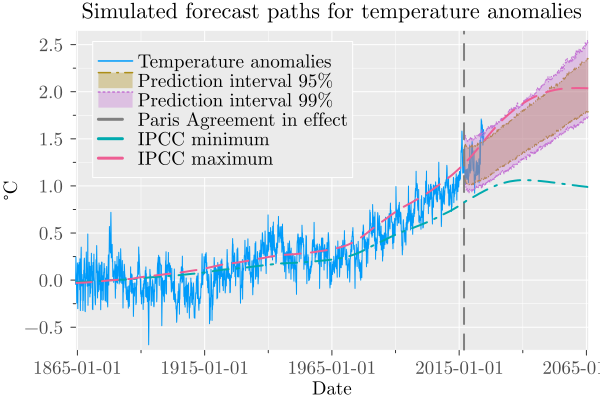

In [29]:
#| label: fig-paths-covprepa
#| fig-cap: Simulated forecast paths for HadCRUT5 temperature anomalies. The 95% and 99% prediction intervals are shown as shaded areas. The IPCC projections for the minimum and maximum temperature anomalies are shown as dashed lines [@IPCCSR15].

plot(rawtemp.Time, menstempind, linewidth=1, label="Temperature anomalies", legend=:topleft, title="Simulated forecast paths for temperature anomalies", xlabel="Date (monthly)", ylabel="°C")
plot!(date_for, quantilesforecasts[:, 2], fillrange=quantilesforecasts[:, 6], fillalpha = 0.35,label="Prediction interval 95%", color=5, linestyle=:auto)
plot!(date_for, quantilesforecasts[:, 6], label="", color=5, linestyle=:auto)
plot!(date_for, quantilesforecasts[:, 1], fillrange=quantilesforecasts[:, 7], fillalpha = 0.35,label="Prediction interval 99%", color=4, linestyle=:dot)
plot!(date_for, quantilesforecasts[:, 7], label="", color=4, linestyle=:dot)
vline!([tempnino.Date[end]], label="Paris Agreement in effect", color=:gray, linewidth=2, linestyle=:dash)
plot!(Date.(ipcc.year), [ipcc.min_t ipcc.max_t], linewidth=2, linestyle=[:dashdot :dash], label=["IPCC minimum" "IPCC maximum"], xlabel="Date", ylabel="°C", legend=:topleft, color = [6 7])
plot!(fontfamily="Computer Modern", legendfontsize=12, tickfontsize=12, titlefontfamily="Computer Modern", legendfontfamily="Computer Modern", tickfontfamily="Computer Modern", ylabelfontsize=12, xlabelfontsize=12, titlefontsize=14, ylims=(-0.65, 2.55), xlims=(Date(1870, 1, 1), Date(2060, 1, 1)))

In [30]:
savefig("figures/Paths-HadCRUT5-PrePA-Coverage.png")

"/Users/jeddy/Library/CloudStorage/OneDrive-AalborgUniversitet/Research/CLIMATE/Paris Goal/Odds-of-breaching-1.5C/figures/Paths-HadCRUT5-PrePA-Coverage.png"

## 6. Estimating the probability of exceeding 1.5°C 
### Using the middle point of the first 20 years period where the mean temperature exceeds 1.5°C

In [31]:
inicio = T - 119 # 10 years starting 2004
fin = T + h - 120 # 10 years

datejoin = collect((tempnino.Date[inicio]):Month(1):date_for[h-120])
meantemp = mean(Matrix(tempnino[inicio:T, 4:203]), dims=2)
dummies = zeros(h, 200 * nsim)

for jj = 1:(200*nsim)
    completo = [meantemp; matforecasts[:, jj]]
    for ii = 120:h
        dummies[ii, jj] = mean(completo[ii-119:ii+120])
    end
end

pa15 = mean(dummies[:, :] .>= 1.5, dims=2);
pa20 = mean(dummies[:, :] .>= 2, dims=2);

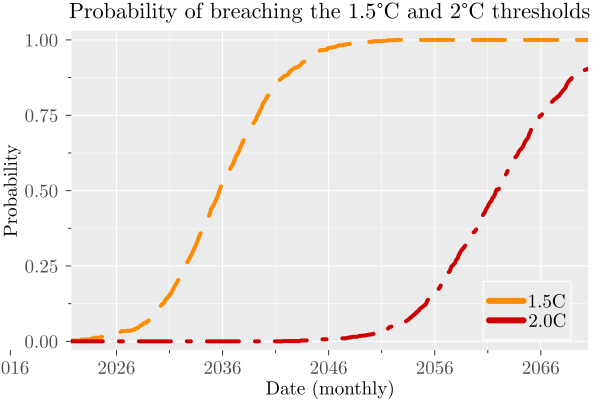

In [32]:
#| label: fig-dist-prepa
#| fig-cap: Proportion of scenarios that breach the 1.5°C and 2°C thresholds for the HadCRUT5 temperature anomalies for each month at the start of the Paris Agreement. The figure considers 1000 scenarios, each based on the best-fitting model for each realization, with five simulations for El Niño as an exogenous variable each.

plot(datejoin, pa15, label="1.5C", color=:darkorange, legend=:bottomright, xlims=(datejoin[120], datejoin[end-48]), xticks=(datejoin[120:120:end], Dates.format.(datejoin[120:120:end], "Y")), linewidth=4, linestyle=:dash, title="Probability of breaching the 1.5°C and 2°C thresholds", xlabel="Date (monthly)", ylabel="Probability")
plot!(datejoin, pa20, label="2.0C", color=:red3, linewidth=4, linestyle=:dashdot)
plot!(fontfamily="Computer Modern", legendfontsize=12, tickfontsize=12, titlefontfamily="Computer Modern", legendfontfamily="Computer Modern", tickfontfamily="Computer Modern", ylabelfontsize=12, xlabelfontsize=12, titlefontsize=14, ylims=(0, 1), xlims=(Date(2024, 1, 1), Date(2070, 1, 1)))

In [33]:
savefig("figures/Coverage-HadCRUT5-PrePA.png")

"/Users/jeddy/Library/CloudStorage/OneDrive-AalborgUniversitet/Research/CLIMATE/Paris Goal/Odds-of-breaching-1.5C/figures/Coverage-HadCRUT5-PrePA.png"

Determning the first month where the probability of exceeding 1.5°C and 2°C is greater than 0%.

In [34]:
display(datejoin[findfirst(pa15 .> 0)])
display(datejoin[findfirst(pa20 .> 0)])

2022-07-01

2042-09-01

Determining the first month that the probability of exceeding 1.5°C and 2°C is greater than 99%.

In [35]:
display(datejoin[findfirst(pa15 .>= 0.99)])

2049-09-01

In [36]:
date_for[end]

2083-08-01